# Exercise 3
## Generative adversarial networks
### Generating of MNIST digits with a GAN

First we import the modules we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Setup our MNIST dataloaders

In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 73707697.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4881551.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32666043.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12418858.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [167]:
batch_size = 64
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 67497511.64it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2339239.29it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 31501710.49it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7906362.87it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Implement your **generator** network as a fully connected neural network.

You could start with a network that:
* takes as input a 100 long vector
* has four hidden layers with 2848 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [168]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100,2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048,2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048,2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048,784),
            nn.Tanh()
            )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has no activation on the final layer (we will call sigmoid if we want a probability)

In [169]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28,1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256,1)
            )
       

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Now let's train our model

In [170]:
#Initialize networks
def train_GAN():
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 10
    discriminator_final_layer = torch.sigmoid

    # Use BCE loss with logits
    BCE_loss = nn.BCEWithLogitsLoss()


    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)

            target = torch.ones(x.shape[0],1).to(device)
            
            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.

            d_loss = BCE_loss(d(x_real), target).mean() + BCE_loss(d(x_fake.detach()), 1-target).mean()
            d_loss.backward()
            d_opt.step()

            #Update generator
            g.zero_grad()
            g_loss = BCE_loss(d(x_fake), target).mean()
            g_loss.backward()
            g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


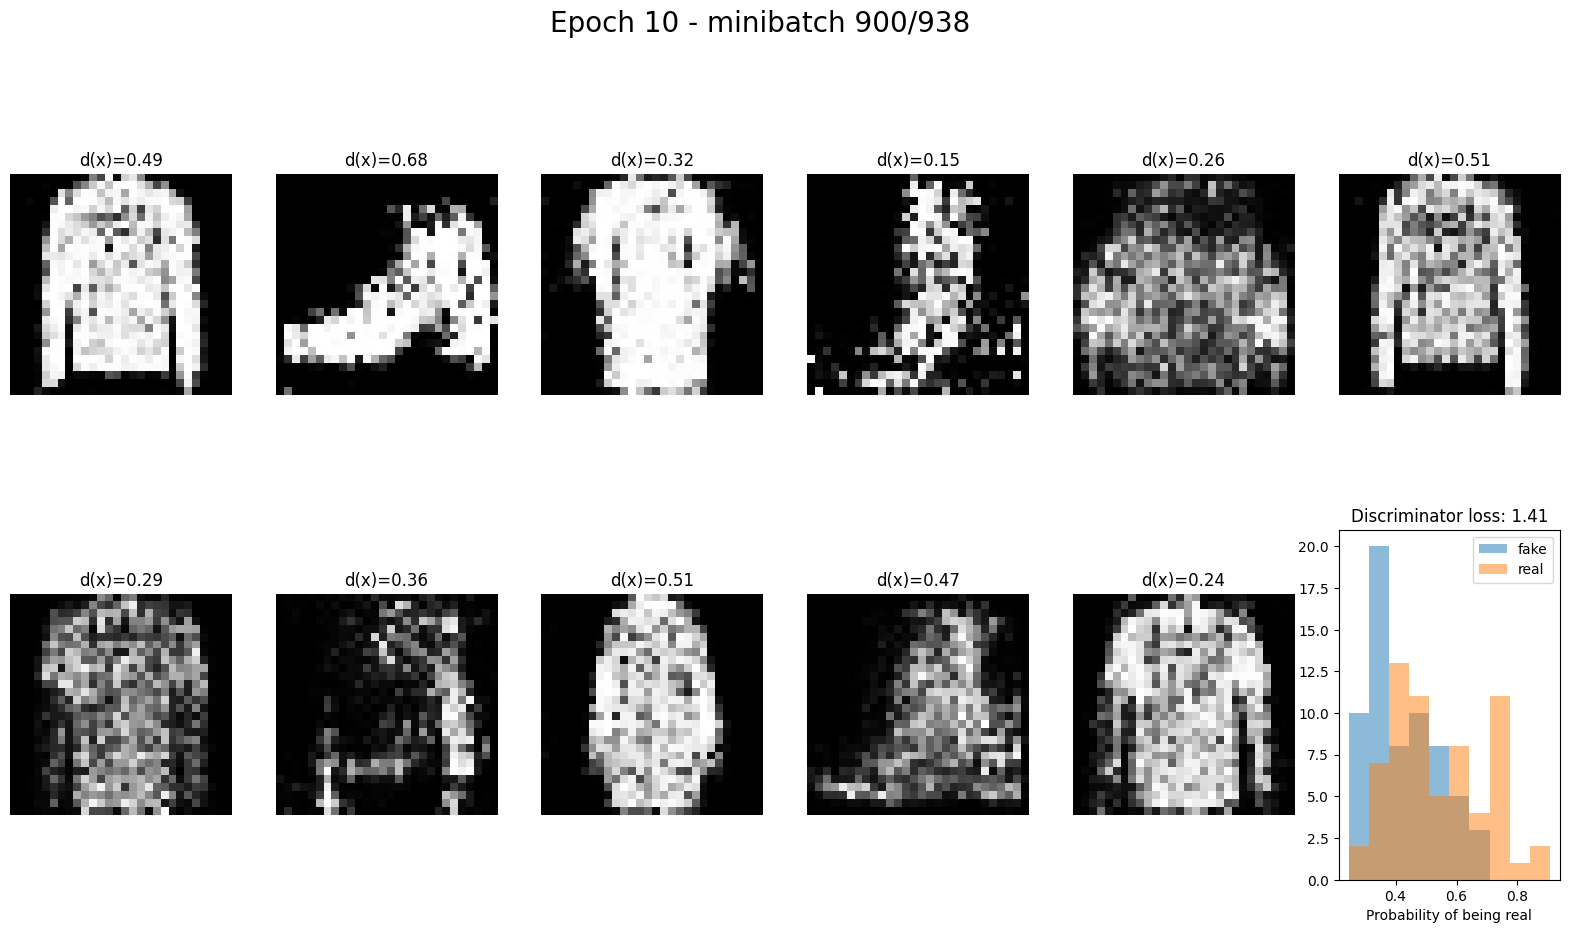

In [171]:
train_GAN()

Do you get a model to generate nice images?

The plot shows probabilities of real and generated digits being classified as real. Is the discriminator able to distinguish real from fake? If not, try increasing the capacity of the discriminator.
Feel free to change the architecture as you see fit.

## Additional tasks
* Change the architecture to get better results
* Implement an LSGAN
* Implement a WGAN with SN
* Convert your network to a DCGAN
* Visualize what happens when you interpolate between to points in the latent space
* Generate images from FashionMNIST

### Harder tasks:
* Add data augmentation to fake and real images
* Use the data augmentation to the generated images
* Convert your architecture into an AC-GAN

In [40]:
#Initialize networks
def train_LSGAN(a=-1,b=1,c=0):
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 10
    discriminator_final_layer = torch.sigmoid

    # Use least squares loss
    MSE_loss = nn.MSELoss()


    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)
            aa = a*torch.ones(x.shape[0],1).to(device)
            bb = b*torch.ones(x.shape[0],1).to(device)
            cc = c*torch.ones(x.shape[0],1).to(device)
            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
            d_loss = 1/2*MSE_loss(d(x_real), bb).mean() + 1/2*MSE_loss(d(x_fake.detach()), aa).mean()
            d_loss.backward()
            d_opt.step()

            #Update generator
            g.zero_grad()
            g_loss = 1/2*MSE_loss(d(x_fake), cc).mean()
            g_loss.backward()
            g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


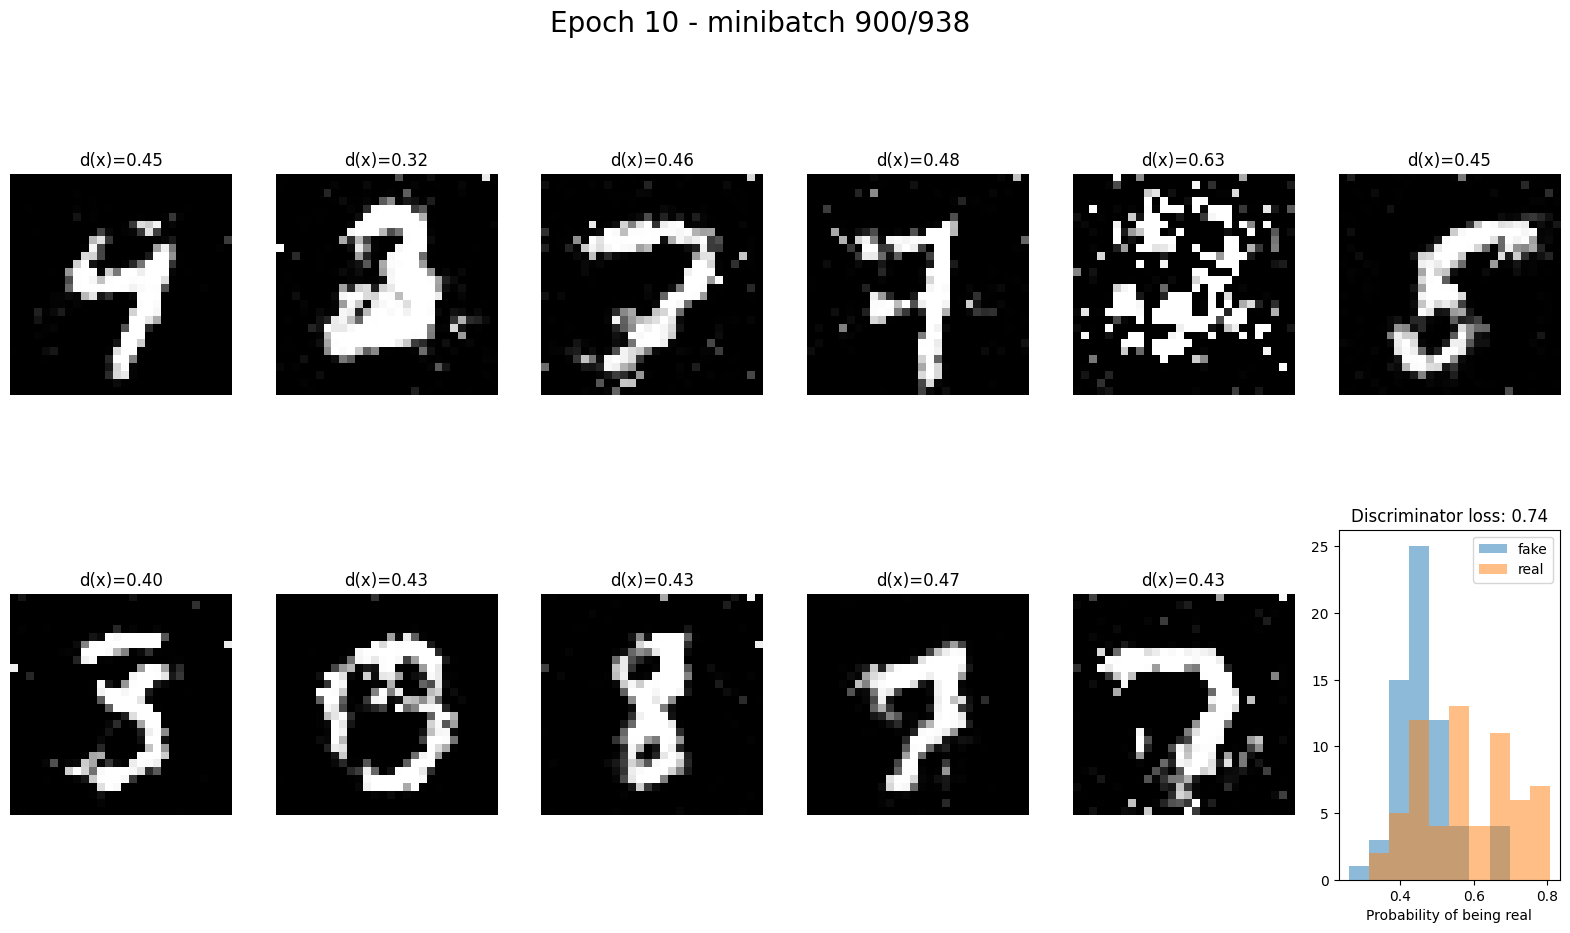

In [41]:
train_LSGAN()

In [43]:
#Initialize networks
def train_LSGAN(a=-1,b=1,c=0):
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 5
    discriminator_final_layer = torch.sigmoid

    # Use least squares loss
    MSE_loss = nn.MSELoss()


    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)
            aa = a*torch.ones(x.shape[0],1).to(device)
            bb = b*torch.ones(x.shape[0],1).to(device)
            cc = c*torch.ones(x.shape[0],1).to(device)
            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
            d_loss = 1/2*MSE_loss(discriminator_final_layer(d(x_real)), bb).mean() + 1/2*MSE_loss(discriminator_final_layer(d(x_fake.detach())), aa).mean()
            d_loss.backward()
            d_opt.step()

            #Update generator
            g.zero_grad()
            g_loss = 1/2*MSE_loss(discriminator_final_layer(d(x_fake)), cc).mean()
            g_loss.backward()
            g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


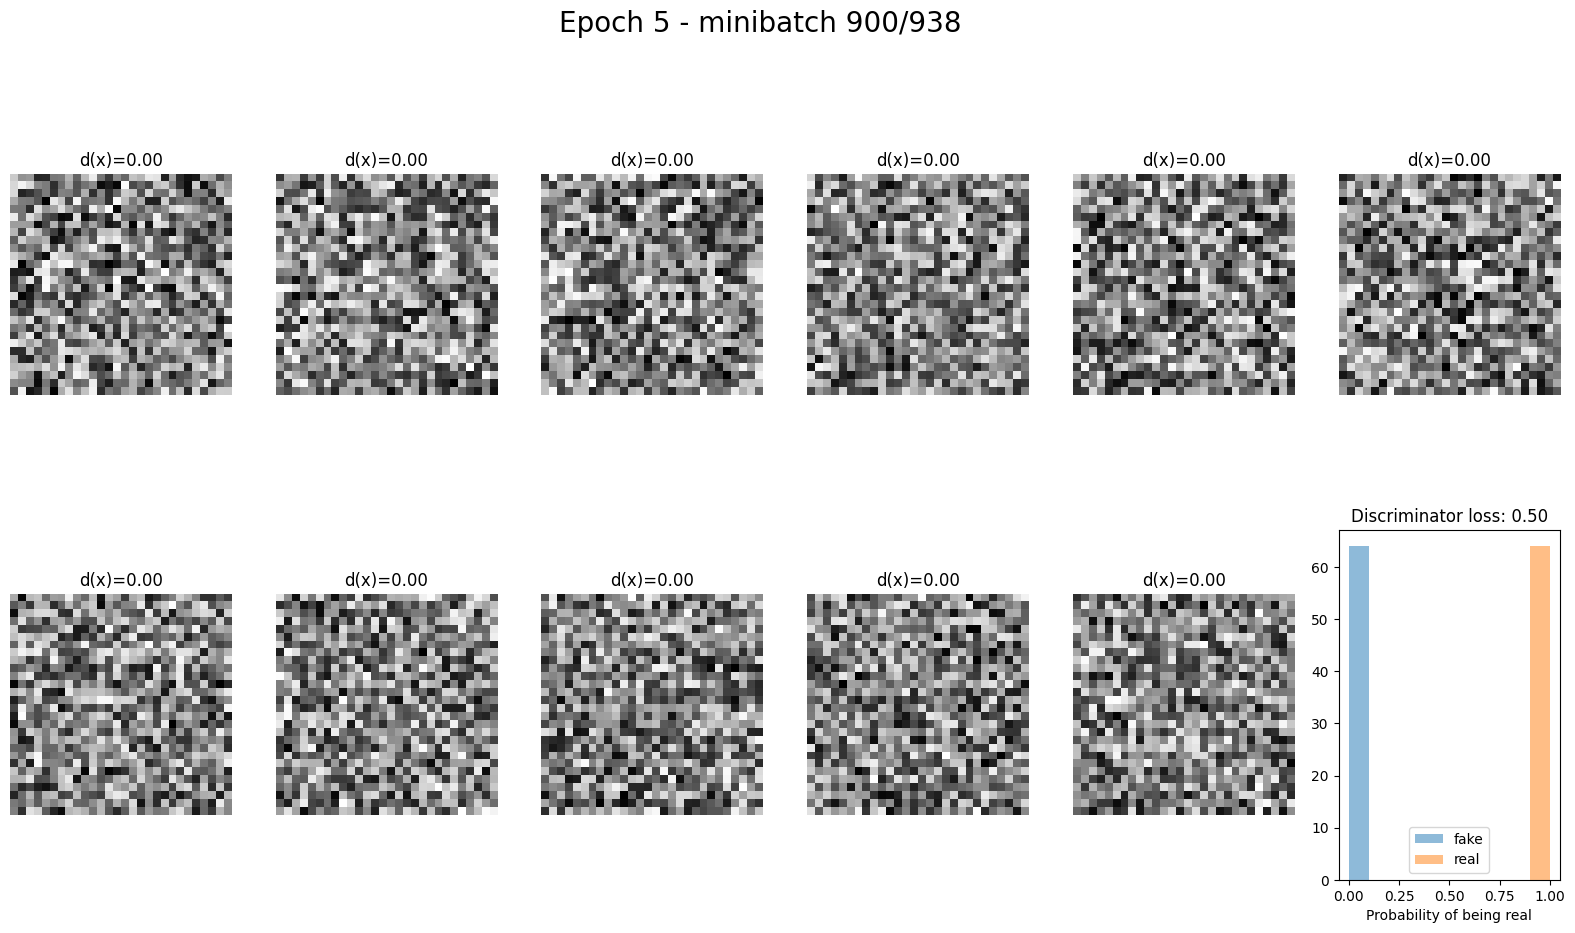

In [44]:
train_LSGAN()

In [45]:
#Initialize networks
def train_WGAN():
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 10
    discriminator_final_layer = torch.sigmoid




    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)

            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
            d_loss = -(d(x_real).mean() + d(x_fake.detach()).mean())
            d_loss.backward()
            d_opt.step()

            #Update generator
            #g.zero_grad()
            #g_loss = 1/2*MSE_loss(d(x_fake), cc).mean()
            #g_loss.backward()
            #g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


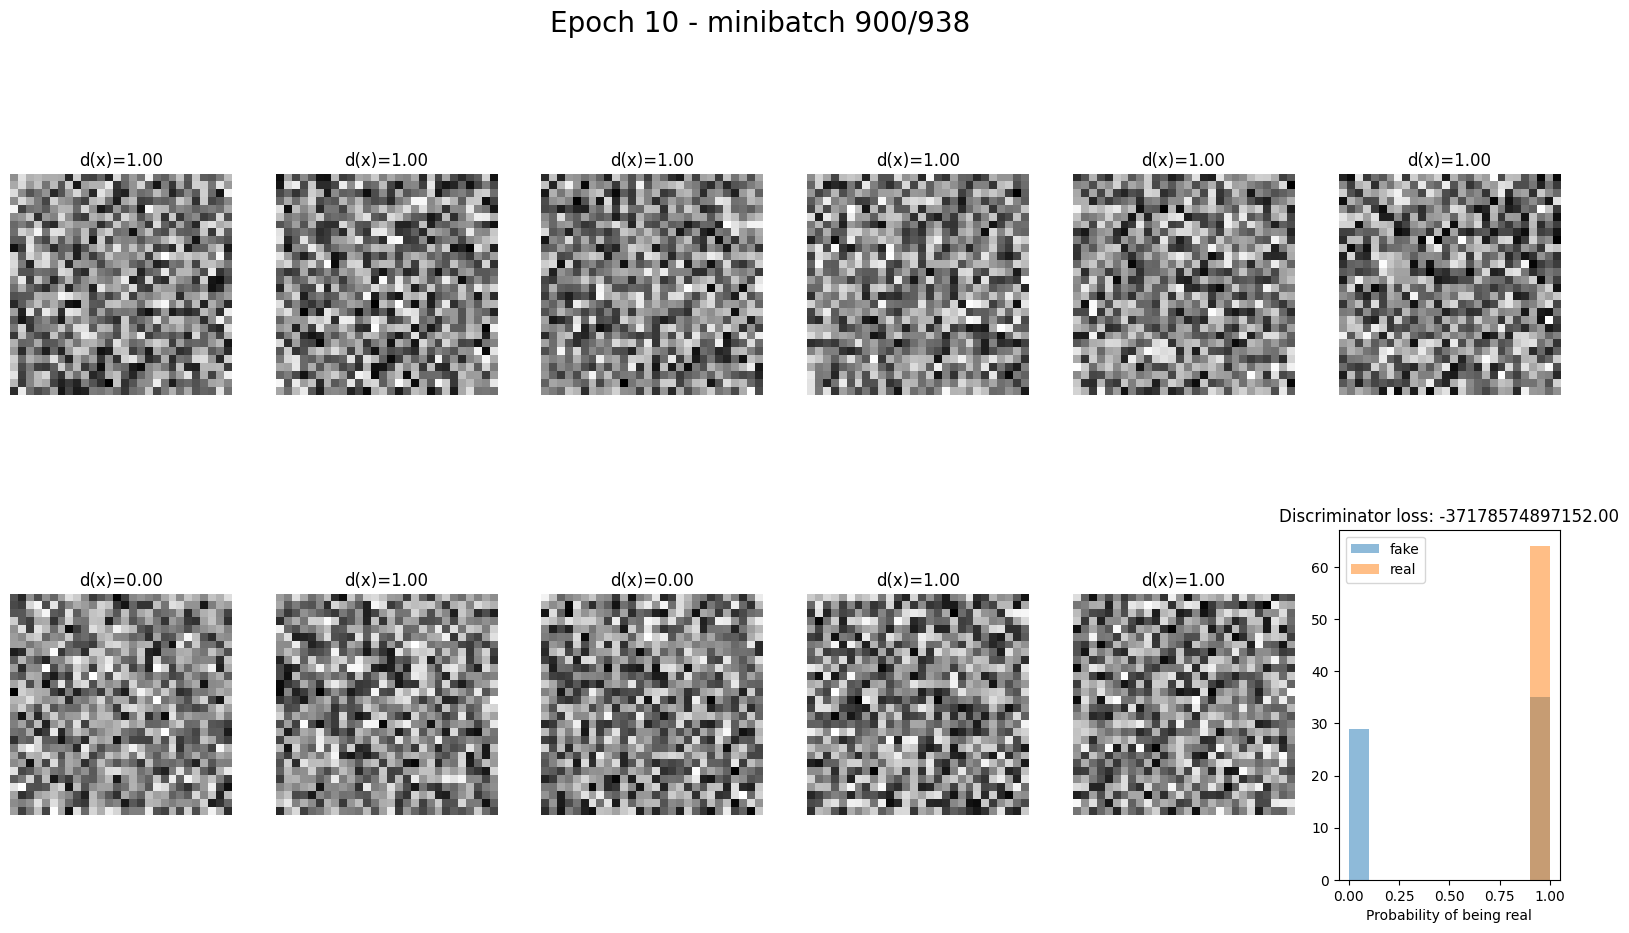

In [46]:
train_WGAN()

In [172]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100,6272),
            nn.LeakyReLU(),
            nn.BatchNorm1d(6272),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = self.conv(x)
        #print(x.shape)
        return x

In [173]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                nn.LeakyReLU(),
                nn.Dropout(),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Dropout(),
                nn.BatchNorm2d(128),
        )
        self.fc = nn.Linear(25088, 1)
       

    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [174]:
#Initialize networks
def train_GAN():
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 5
    discriminator_final_layer = torch.sigmoid

    # Use BCE loss with logits
    BCE_loss = nn.BCEWithLogitsLoss()


    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            # pad to size 32x32
            #x_real = F.pad(x_real, (2,2,2,2), 'constant', 0)
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)

            target = torch.ones(x.shape[0],1).to(device)
            
            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.

            d_fake_out = discriminator_final_layer(d(x_fake.detach()))
            d_real_out = discriminator_final_layer(d(x_real))

            #d_loss = - torch.mean(torch.log(1-d_fake_out + 0.00001) + torch.log(d_real_out + 0.00001))



            d_loss = BCE_loss(d(x_real), target).mean() + BCE_loss(d(x_fake.detach()), 1-target).mean()
            d_loss.backward()
            d_opt.step()

            #Update generator
            g.zero_grad()
            g_loss = BCE_loss(d(x_fake), target).mean()

            #g_loss = -torch.mean(torch.log( discriminator_final_layer(d(x_fake))+ 0.00001))
            
            g_loss.backward()
            g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


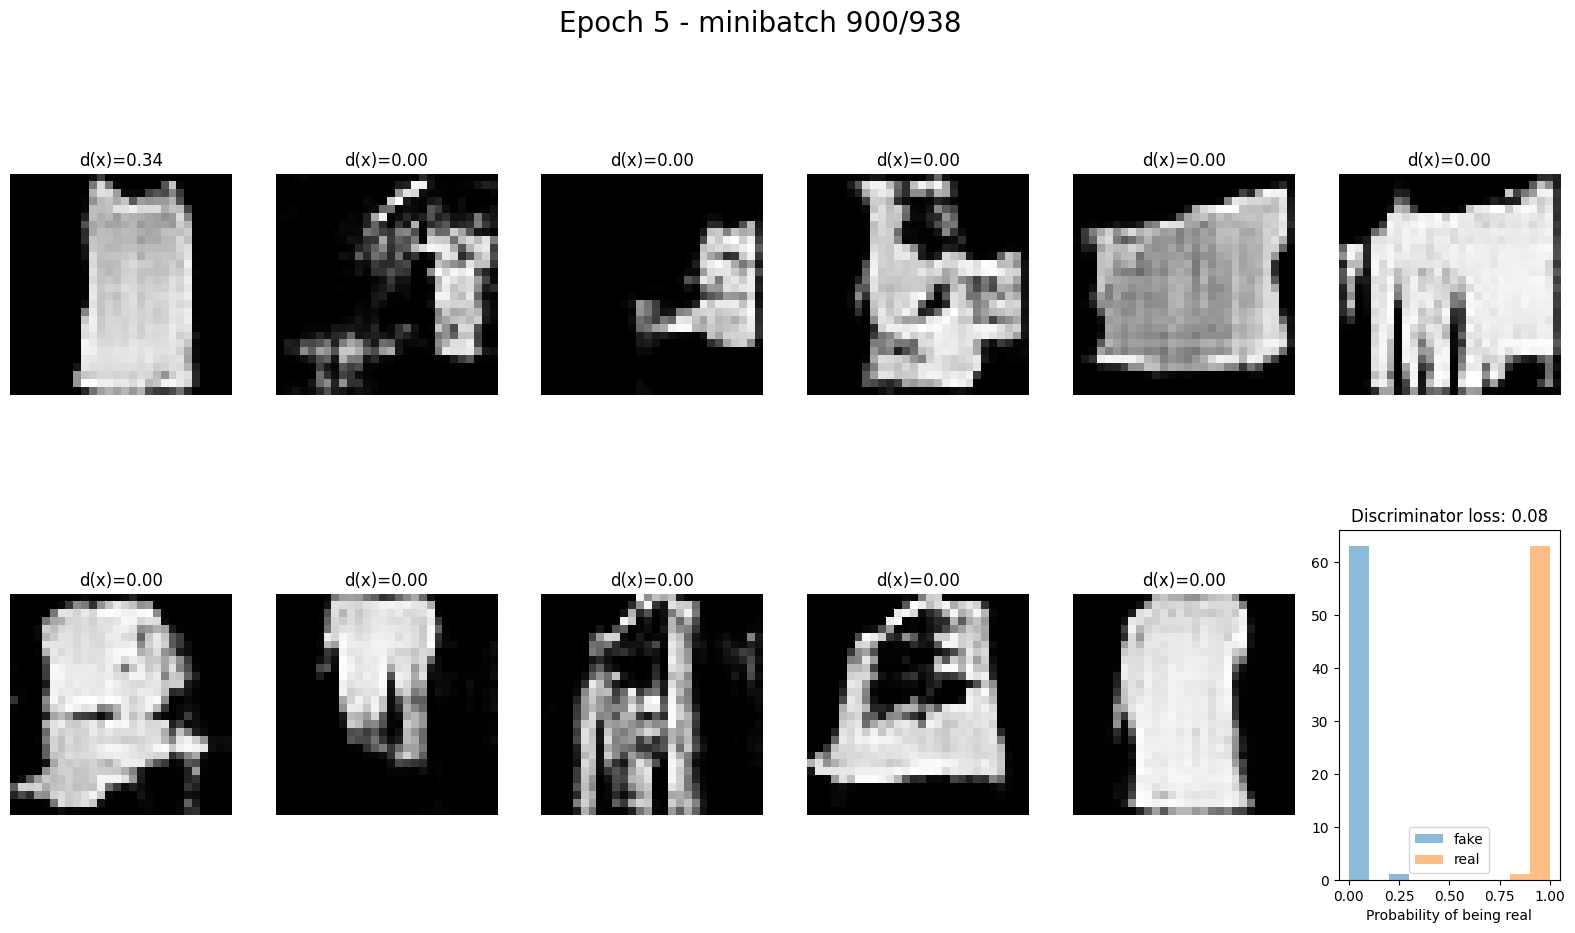

In [175]:
train_GAN()

In [176]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [177]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [180]:
#Initialize networks
def train_GAN():
    d = Discriminator().to(device)
    g = Generator().to(device)
    d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
    g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

    plt.figure(figsize=(20,10))
    subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
    num_epochs = 5
    discriminator_final_layer = torch.sigmoid

    # Use BCE loss with logits
    BCE_loss = nn.BCEWithLogitsLoss()


    for epoch in range(num_epochs):
        for minibatch_no, (x, target) in enumerate(train_loader):
            x = F.pad(x, (2,2,2,2), 'constant', 0)
            x_real = x.to(device)*2-1 #scale to (-1, 1) range
            # pad to size 32x32
            
            z = torch.randn(x.shape[0], 100).to(device)
            x_fake = g(z)

            target = torch.ones(x.shape[0],1).to(device)
            
            #Update discriminator
            d.zero_grad()
            #remember to detach x_fake before using it to compute the discriminator loss
            #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.

            d_fake_out = discriminator_final_layer(d(x_fake.detach()))
            d_real_out = discriminator_final_layer(d(x_real))

            #d_loss = - torch.mean(torch.log(1-d_fake_out + 0.00001) + torch.log(d_real_out + 0.00001))



            d_loss = BCE_loss(d(x_real), target).mean() + BCE_loss(d(x_fake.detach()), 1-target).mean()
            d_loss.backward()
            d_opt.step()

            #Update generator
            g.zero_grad()
            g_loss = BCE_loss(d(x_fake), target).mean()

            g_loss = -torch.mean(torch.log( discriminator_final_layer(d(x_fake))+ 0.00001))
            
            g_loss.backward()
            g_opt.step()
            assert(not np.isnan(d_loss.item()))
            #Plot results every 100 minibatches
            if minibatch_no % 100 == 0:
                with torch.no_grad():
                    P = discriminator_final_layer(d(x_fake))
                    for k in range(11):
                        x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                        subplots[k].imshow(x_fake_k, cmap='gray')
                        subplots[k].set_title('d(x)=%.2f' % P[k])
                        subplots[k].axis('off')
                    z = torch.randn(batch_size, 100).to(device)
                    H1 = discriminator_final_layer(d(g(z))).cpu()
                    H2 = discriminator_final_layer(d(x_real)).cpu()
                    plot_min = min(H1.min(), H2.min()).item()
                    plot_max = max(H1.max(), H2.max()).item()
                    subplots[-1].cla()
                    subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                    subplots[-1].legend()
                    subplots[-1].set_xlabel('Probability of being real')
                    subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                    title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                    plt.gcf().suptitle(title, fontsize=20)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


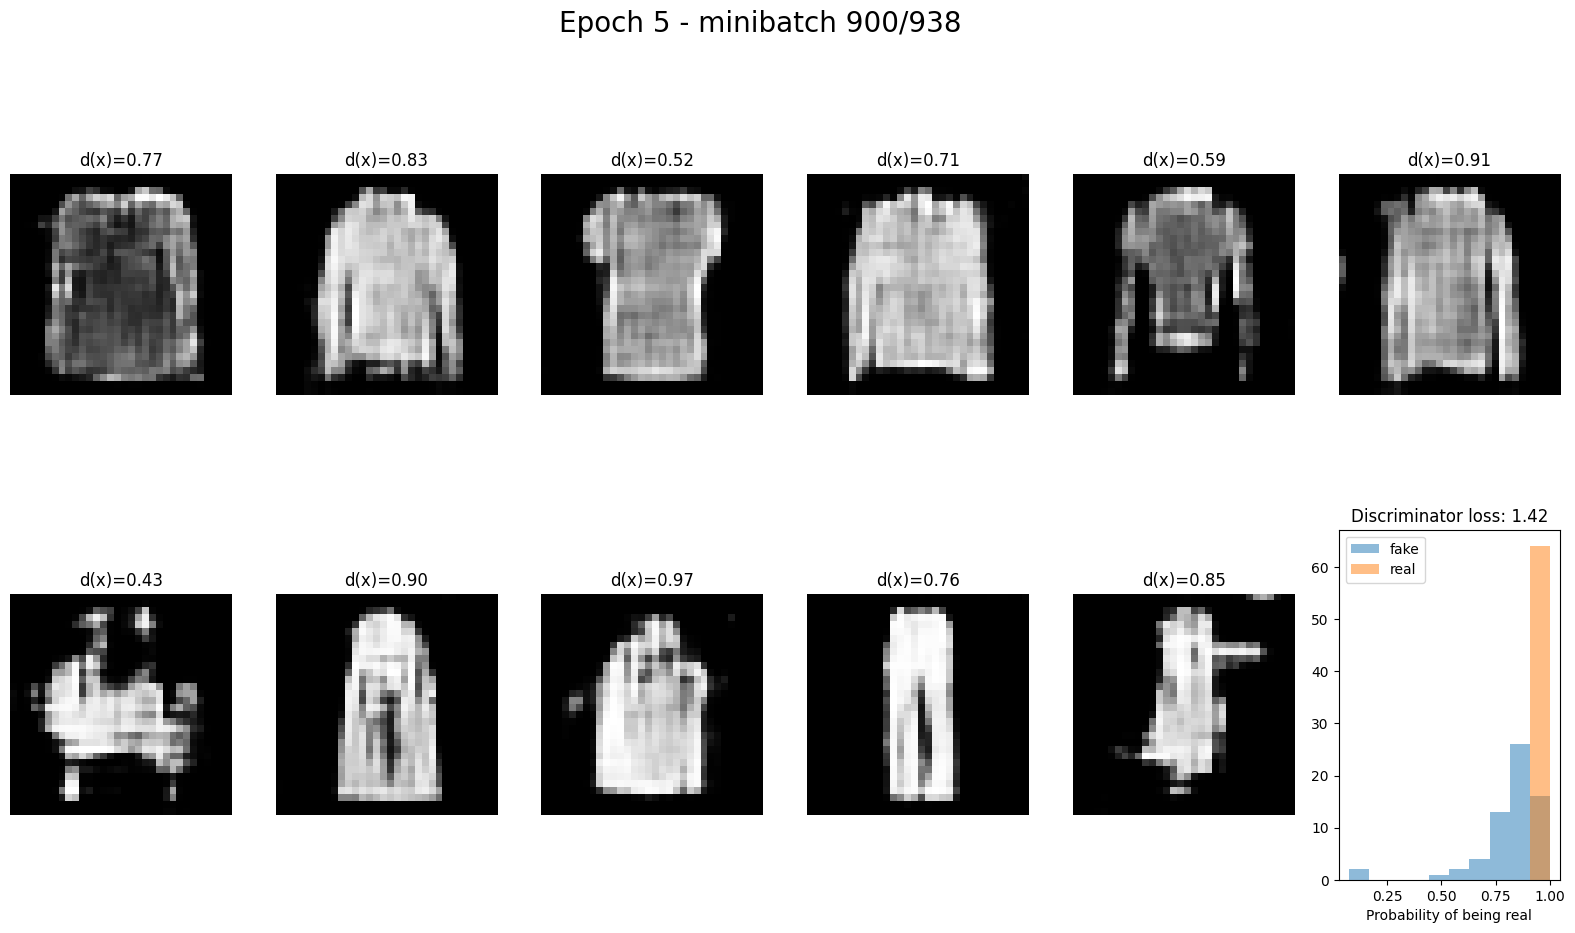

In [181]:
train_GAN()